<a href="https://colab.research.google.com/github/gmarcelo94/sn-AI-ke/blob/main/snAIke_Algorithm__Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
from random import seed
from random import randint
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, RandomFlip
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [ ]:
# With GitHub there is no need for Drive mounting
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!git clone https://github.com/gmarcelo94/sn-AI-ke         #cloaning repository GitHub to local environment 

Cloning into 'sn-AI-ke'...
remote: Enumerating objects: 1290, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 1290 (delta 46), reused 5 (delta 1), pack-reused 1212
Receiving objects: 100% (1290/1290), 298.81 MiB | 13.91 MiB/s, done.
Resolving deltas: 100% (76/76), done.
Checking out files: 100% (1169/1169), done.


# Set-up Snake Info and Snake Antivenom dataframes:

In [ ]:
#snake common name and correspondent info
df_snakes = pd.read_excel (r'sn-AI-ke/Snake info.xlsx', sheet_name='Most Venomous Snakes')
#print(df_snakes.head(6))
print(df_snakes.shape[0])         
print(df_snakes.shape[1])

78
7


In [ ]:
#snake scientific name and correspondent antivenom info
df_antivenoms = pd.read_excel (r'sn-AI-ke/Snake info.xlsx', sheet_name='Antivenoms WHO database') #https://github.com/gmarcelo94/sn-AI-ke/blob/main/Snake%20info.xlsx?raw=true
print (df_antivenoms.head(6))
print(df_antivenoms.shape[0])       
print(df_antivenoms.shape[1])

      Scientific_Name                                Antivenom  \
0  Ophiophagus hannah  Neuro-polyvalent snake antivenom (QSMI)   
1  Ophiophagus hannah              King cobra antivenin (QSMI)   
2  Bungarus caeruleus        Snake Venom Antiserum I.P. (Asia)   
3  Bungarus caeruleus               Snake venom antiserum I.P.   
4  Bungarus caeruleus   Polyvalent Anti Snake Venom Serum I.P.   
5  Bungarus caeruleus        Polyvalent Snake Antivenin (Asia)   

                                   Manufacturer_Name Manufacturer_Country  \
0                  Queen Saovabha Memorial Institute             Thailand   
1                  Queen Saovabha Memorial Institute             Thailand   
2                               VINS Bioproducts Ltd                India   
3              Premium Serums and Vaccines Pvt. Ltd.                India   
4  King Institute of Preventative Medicine and Re...                India   
5                               Biological E Limited                India  

# Data Loading and Preprocessing:

1151
[11.29 22.07 12.08 13.29 20.33 20.94]


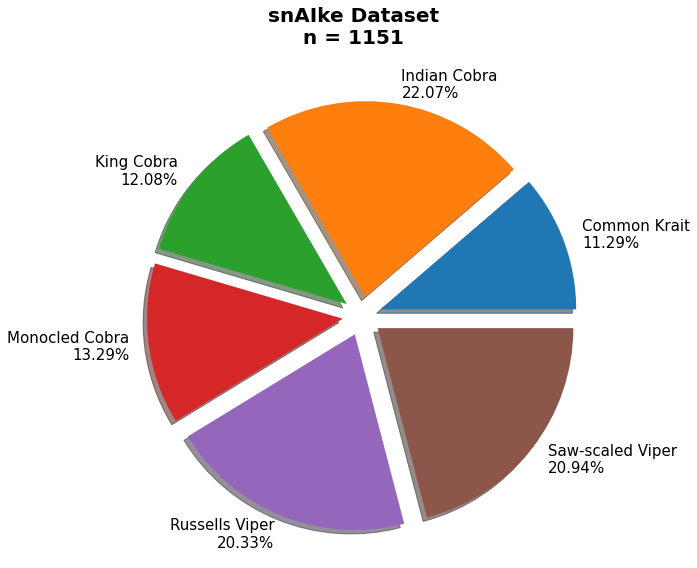

In [ ]:
#ploting with pie chart the percentages of the snake species on the dataset
y = np.array([130, 254, 139, 153, 234, 241])        

sum_snakes =  np.amax(np.cumsum(y))
print(sum_snakes)
y_percent = np.round(((y/sum_snakes)*100), 2)
print(y_percent)
mylabels = [f'Common Krait\n{y_percent[0]}%', 
            f'Indian Cobra\n{y_percent[1]}%', 
            f'King Cobra\n{y_percent[2]}%', 
            f'Monocled Cobra\n{y_percent[3]}%', 
            f'Russells Viper\n{y_percent[4]}%', 
            f'Saw-scaled Viper\n{y_percent[5]}%']

myexplode = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

plt.figure(figsize=(10,9))
plt.pie(y, labels = mylabels, explode = myexplode, shadow = True, textprops = dict(fontsize=15))

_ = plt.suptitle(f'snAIke Dataset\nn = {sum_snakes}', weight='bold', fontsize=20)
plt.show()

In [ ]:
#selecting a batch size and resize de images
batch_size = 32           
img_height = 224
img_width = 224

In [ ]:
path = "sn-AI-ke/Venomous" # Once cloned the repository is available localy and the path point to the folder of interest

In [ ]:
# Here each dataset is created by fetching the data from the directory Venomous, inside the sn-AI-ke reporsitory
# There is no longer need to have the folder locally and unzipped as it can fetch directly from GitHub

ds_train = tf.keras.utils.image_dataset_from_directory(
    path, #'/content/drive/MyDrive/SnakeTeam_SamsungAI/Venomous.zip',
    labels =  'inferred',
    label_mode = "int",    #int ou string
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split = 0.2,
    subset = "training",
)


val_ds= tf.keras.utils.image_dataset_from_directory(
    path, #'/content/drive/MyDrive/SnakeTeam_SamsungAI/Venomous.zip (Unzipped Files)/Venomous',
    labels =  'inferred',
    label_mode = "int",    #int ou string
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split = 0.2,
    subset = "validation",
)

# Splitting of above val_ds into final validation and test datased (ds_val & ds_test)
l = len(val_ds)
ratio = int(0.5*l)
# print(ratio)
ds_test = val_ds.take(ratio)
ds_val = val_ds.skip(ratio)

Found 1151 files belonging to 6 classes.
Using 921 files for training.
Found 1151 files belonging to 6 classes.
Using 230 files for validation.


In [ ]:
#number of batches per training, testing and validating 
print('Batches for training -->', ds_train.cardinality())         
print('Batches for testing -->', ds_test.cardinality())
print('Batches for validating -->', ds_val.cardinality())

Batches for training --> tf.Tensor(29, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(4, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(4, shape=(), dtype=int64)


# Exploratory Data Analysis (EDA):

In [ ]:
#specifing each class in the dataset and the total number of classes in the dataset
class_names = np.array(ds_train.class_names)
print(class_names)
class_num = class_names.size
print(f'The total number of classes in the Dataset is of {class_num}')

['Common Krait' 'Indian Cobra' 'King Cobra' 'Monocled Cobra'
 "Russell's Viper" 'Saw-scaled Viper']
The total number of calsses in the Dataset is of 6


In [ ]:
#unbatching the traing dataset and storage in an explorable dataframe
ds_explore = ds_train.unbatch()
df = pd.DataFrame(ds_explore.map(lambda x,y: (x,y)))

In [ ]:
df.shape

(921, 2)

Check the number of images per existing class:

In [ ]:
#counting the indexes -> number of classes in the dataset
indexes=[]

for c in range(df.shape[0]):
   indexes.append(int(np.array(df[1][c])))

In [ ]:
#counting the number of images per class in the dataset related the the training
df2 = pd.DataFrame(indexes)
df_counts = df2[0].value_counts(sort = False, ascending = True)
print(df_counts)

1    204
5    200
2    103
4    193
0    104
3    117
Name: 0, dtype: int64


In [ ]:
#number of images for training in the first class
df_counts[0]

104

In [ ]:
#total images for the traing model
class0 = df_counts[0]
class1 = df_counts[1]
class2 = df_counts[2]
class3 = df_counts[3]
class4 = df_counts[4]
class5 = df_counts[5]

d = len(df_counts)
total=0
for u in range(d):
  total = total + df_counts[u]

print(total)

921


Class weigths calculation:

In [ ]:
# Scaling by total/6 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = np.round((1 / class0) * (total / d),2)
weight_for_1 = np.round((1 / class1) * (total / d),2)
weight_for_2 = np.round((1 / class2) * (total / d),2)
weight_for_3 = np.round((1 / class3) * (total / d),2)
weight_for_4 = np.round((1 / class4) * (total / d),2)
weight_for_5 = np.round((1 / class5) * (total / d),2)

In [ ]:
#Can use the class names for x axis
yaxis = []

for k in range(df_counts.shape[0]):
    yaxis.append(100*df_counts[k]/total)

New_Colors = ['green', 'teal', 'blue','purple','red','brown']
ind = np.arange(len(y))
plt.bar(class_names, yaxis, color=New_Colors)
for dindex,data in enumerate(yaxis):
    plt.text(x=dindex-0.25 , y = data+1 , s=f"{np.round(data,1)}" , fontdict=dict(fontsize=14))
plt.title('Classes Distribution in Training Dataset', fontsize=14)
plt.ylim(top=30)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Class participation / %', fontsize=14)
plt.xticks(rotation=45)
plt.show()


In [ ]:
#classes weight considering the distribution in dataset
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4, 5: weight_for_5}
print(class_weight)

{0: 1.48, 1: 0.75, 2: 1.49, 3: 1.31, 4: 0.8, 5: 0.77}


In [ ]:
#normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)
ds_train = ds_train.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
ds_val = ds_val.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
ds_test = ds_test.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [ ]:
# contrast_layer = tf.keras.layers.RandomContrast(factor=(0.5, 1.5), seed=123) # seed=123
# ds_train = ds_train.map(lambda x, y: (contrast_layer(x), y)) # Where x—images, y—labels.
# ds_val = ds_val.map(lambda x, y: (contrast_layer(x), y)) # Where x—images, y—labels.
# ds_test = ds_test.map(lambda x, y: (contrast_layer(x), y)) # Where x—images, y—labels.

In [ ]:
#sizing the autotune related with the cache
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#selected batches on the images, labels and train
for image_batch, labels_batch in ds_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
#selected batches on the images, labels and test
for image_batch2, labels_batch2 in ds_test:
  print(image_batch2.shape)
  print(labels_batch2.shape)
  break

(32, 224, 224, 3)
(32,)


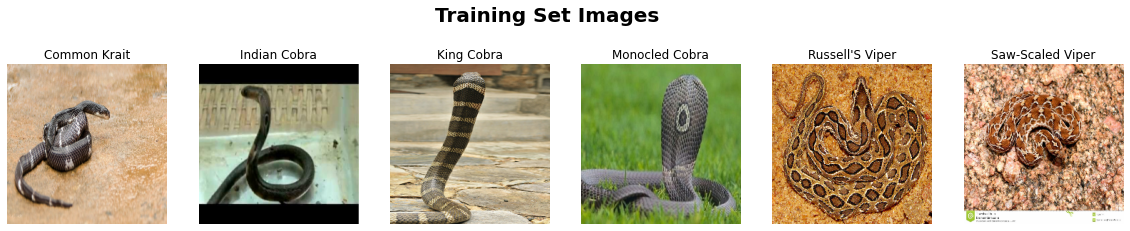

In [ ]:
#Training set images with correspondent label for each class
pindex=0
plt.figure(figsize=(20,4))
plt.subplots_adjust(hspace=0.15)

for image, lable in ds_train.unbatch():
  if lable.numpy() == pindex:
    plt.subplot(1,6,pindex+1)
    plt.imshow(image)
    plt.title(class_names[lable.numpy()].title())
    pindex += 1
  else:
    
      pass
  plt.axis('off')
_ = plt.suptitle("Training Set Images", weight='bold', fontsize = 20)

  # break

# Data Augmentation and Expansion:

Set and visualize augmentation

In [ ]:
#augmentation of the images
RandomFlip = tf.keras.layers.RandomFlip("horizontal_and_vertical")
RandomRotation = tf.keras.layers.RandomRotation(factor=(0.25, 0.80), fill_mode='nearest')
RandomZoom = tf.keras.layers.RandomZoom(height_factor=(-0.5, 0.5), width_factor=(-0.5, 0.5))
RandomTranslation = tf.keras.layers.RandomTranslation(0.5, 0.5, fill_mode='reflect', interpolation='bilinear')
GaussNoise = tf.keras.layers.GaussianNoise(1.5)

In [ ]:
#plotting the images with de correspondent label
def plot_image (image, lable):
  plt.subplot(6,5,kindex+1)
  plt.imshow(image)
  plt.title(class_names[lable.numpy()].title(), fontsize = 20)
  plt.axis('off')

In [ ]:
#Augmented Training Set Images
index=0
kindex = 0
plt.figure(figsize=(35,40))
plt.subplots_adjust(hspace=0.15)
ds_exp = ds_train.unbatch()

for image2, lable2 in ds_exp:

  if lable2.numpy() == index:


    for jindex in range(class_names.size):
      
      if jindex == 0:
        plot_image(image2, lable2)
        kindex += 1
        
      elif jindex == 1:
        image_1 = RandomTranslation(image2)
        plot_image(image_1, lable2)
        kindex += 1
        
      elif jindex == 2:
        image_2 = RandomFlip(image2)
        plot_image(image_2, lable2)
        kindex += 1

      elif jindex == 3:
        image_3 = RandomRotation(image2)
        plot_image(image_3, lable2)
        kindex += 1

      elif jindex == 4:
        image_4 = RandomZoom(image2)
        plot_image(image_4, lable2)
        kindex += 1

      # elif jindex == 5:    
      #   image_5 = RandomNoise(image2)
      #   plot_image(image_5, lable2)
      #   kindex += 1
      
        index += 1
 
  
      

  plt.axis('off')
_ = plt.suptitle("Augmented Training Set Images", weight='bold', fontsize = 40)

  # break

Augmentation and Expansion

In [ ]:
#augmented traing set concatenation
ds_1 = ds_train.map(lambda x, y: (RandomTranslation(x), y))
ds_2 = ds_train.map(lambda x, y: (RandomFlip(x), y))
ds_3 = ds_train.map(lambda x, y: (RandomRotation(x), y))
ds_4 = ds_train.map(lambda x, y: (RandomZoom(x), y))
ds_5 = ds_train.map(lambda x, y: (GaussNoise(x), y))
ds_train_aug = ds_train.concatenate(ds_1)
ds_train_aug = ds_train_aug.concatenate(ds_2)
ds_train_aug = ds_train_aug.concatenate(ds_3)
ds_train_aug = ds_train_aug.concatenate(ds_4)
ds_train_aug = ds_train_aug.concatenate(ds_5)

In [ ]:
pd.DataFrame(ds_train_aug.map(lambda x,y: (x,y)).unbatch()).shape

(5526, 2)

In [ ]:
print('Batches for training -->', ds_train_aug.cardinality())

Batches for training --> tf.Tensor(174, shape=(), dtype=int64)


# Fetch Feature Vector model:

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

Any <a href="https://tfhub.dev/s?module-type=image-feature-vector&q=tf2" class="external">compatible image feature vector model</a> from TensorFlow Hub will work here, including the examples from the drop-down menu.

In [ ]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" # 224x224
mobilenet_small_100_v3 = "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5" # 224x224
mobilenet_small_075_v3 = "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5" # 224x224
mobilenet_large_100_v3 = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5" # 224x224
mobilenet_large_075_v3 = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5" # 224x224

efficientnet_v2_b0 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2" # 224x224
efficientnet_v2_ft1k_b0 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2" # 224x224

feature_extractor_model = efficientnet_v2_ft1k_b0 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

# Feature Extractor Layer:

Create the feature extractor by wrapping the pre-trained model as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [ ]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(img_height, img_width, 3),
    trainable=False)

The feature extractor returns a 1280-long vector for each image (the image batch size remains at 32 in this example):

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


# Sn{AI}ke model with attached head, data augmentation and classification layers:

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` model and add a fully-connected layer for classification:

In [ ]:
num_classes = len(class_names)

snAIke = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes)
])

In [ ]:
snAIke.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 5,926,998
Trainable params: 7,686
Non-trainable params: 5,919,312
_________________________________________________________________


Dropout might bring training and validation closer or even rise validation accuracy above that of training making the model more robust at validation/testing.

In [ ]:
predictions = snAIke(image_batch)

In [ ]:
predictions.shape

TensorShape([32, 6])

# Model training and Performance visualization:

Use `Model.compile` to configure the training process and add a `tf.keras.callbacks.TensorBoard` callback to create and store logs:

In [ ]:
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=1000, # approx 10 epochs
#     decay_rate=0.9)
# optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

In [ ]:
snAIke.compile(
  optimizer=tf.keras.optimizers.Adam(), # learning rate = 0.0001 or lr_schedule
  # Adam is the best optimizer in image classification (other optimizers did no perform better)
  # Which include Adamax, Adagrad, Adadelta
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc']
)

In [ ]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1, # Enable histogram computation for every epoch.
    write_images=False) 

To visualize the training progress in TensorBoard later, create and store logs an a [TensorBoard callback](https://www.tensorflow.org/tensorboard/get_started#using_tensorboard_with_keras_modelfit).

Due to the inbalanced number of images per class (imbalanced dataset) consider giving class_weigths:

Check: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [ ]:
NUM_EPOCHS = 30

history = snAIke.fit(ds_train_aug,
                    validation_data=ds_val,
                    epochs=NUM_EPOCHS,
                    class_weight=class_weight,
                    callbacks=tensorboard_callback)

Epoch 1/30
174/174 [==============================] - 30s 135ms/step - loss: 0.9932 - acc: 0.6290 - val_loss: 0.4579 - val_acc: 0.8333
Epoch 2/30
174/174 [==============================] - 20s 117ms/step - loss: 0.6030 - acc: 0.7743 - val_loss: 0.3901 - val_acc: 0.8529
Epoch 3/30
174/174 [==============================] - 20s 117ms/step - loss: 0.5029 - acc: 0.8122 - val_loss: 0.3634 - val_acc: 0.8725
Epoch 4/30
174/174 [==============================] - 21s 123ms/step - loss: 0.4694 - acc: 0.8237 - val_loss: 0.3380 - val_acc: 0.8627
Epoch 5/30
174/174 [==============================] - 20s 116ms/step - loss: 0.4272 - acc: 0.8433 - val_loss: 0.3424 - val_acc: 0.8333
Epoch 6/30
174/174 [==============================] - 20s 116ms/step - loss: 0.4085 - acc: 0.8512 - val_loss: 0.3278 - val_acc: 0.8627
Epoch 7/30
174/174 [==============================] - 20s 116ms/step - loss: 0.3835 - acc: 0.8599 - val_loss: 0.3070 - val_acc: 0.8824
Epoch 8/30
174/174 [==============================] - 2

Note: 
A train_acc and val_acc close to each other is a sign of a good model (with augmentation it gets better);
Dropout reduces proximity bias and prevents overfitting.

Start the TensorBoard to view how the metrics change with each epoch and to track other scalar values:

In [ ]:
%load_ext tensorboard

%tensorboard --logdir logs/fit

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


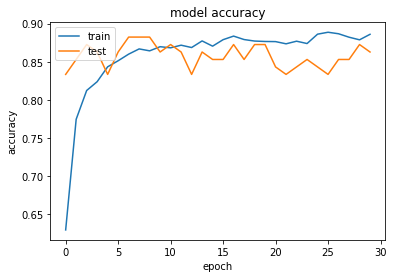

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

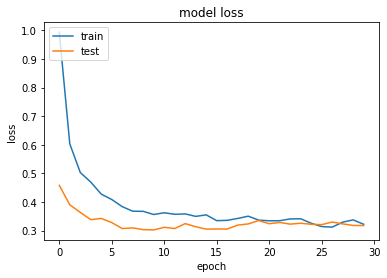

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Check Predictions:


Confusion Matrix plot fuction:

In [ ]:
import seaborn as sns

# Function to create a confusion matrix 
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = np.array(tf.math.confusion_matrix(y_test, pred_test))
    con_mat = pd.DataFrame(con_mat, range(6), range(6))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Greens', cbar=True, linecolor='black')
    plt.xlabel('real classes')
    plt.ylabel('predicted classes')
    plt.title('Confusion Matrix')

    return con_mat

Obtain the ordered list of class names from the model predictions:

In [ ]:
predicted_batch = snAIke.predict(image_batch) #image_batch
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)
print(predicted_id)

['Monocled Cobra' 'Common Krait' 'King Cobra' 'King Cobra'
 "Russell's Viper" 'Common Krait' 'Saw-scaled Viper' 'King Cobra'
 'Indian Cobra' "Russell's Viper" 'Monocled Cobra' 'Indian Cobra'
 'Indian Cobra' 'Common Krait' 'Indian Cobra' 'King Cobra'
 "Russell's Viper" 'Indian Cobra' "Russell's Viper" "Russell's Viper"
 'King Cobra' 'Saw-scaled Viper' "Russell's Viper" 'Saw-scaled Viper'
 "Russell's Viper" 'Saw-scaled Viper' 'Indian Cobra' "Russell's Viper"
 "Russell's Viper" 'Saw-scaled Viper' 'Saw-scaled Viper' 'Monocled Cobra']
tf.Tensor([3 0 2 2 4 0 5 2 1 4 3 1 1 0 1 2 4 1 4 4 2 5 4 5 4 5 1 4 4 5 5 3], shape=(32,), dtype=int64)


In [ ]:
print(labels_batch)

tf.Tensor([3 0 2 2 4 0 5 1 1 4 3 1 1 0 1 2 4 1 4 4 2 5 4 5 4 5 1 5 4 5 5 3], shape=(32,), dtype=int32)


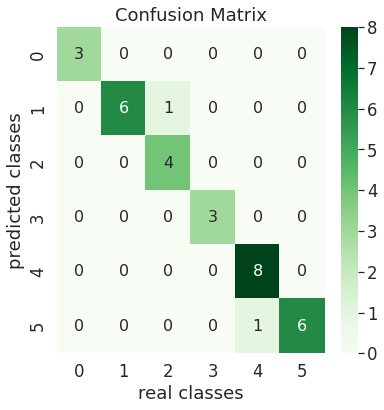

In [ ]:
# Plot Conusion Matix: 
con_mat = conf_matrix(labels_batch, tf.cast(predicted_id, tf.int32))

In [ ]:
FP = con_mat.sum(axis=0) - np.diag(con_mat)  
FN = con_mat.sum(axis=1) - np.diag(con_mat)
TP = np.diag(con_mat)
TN = con_mat.values.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print(f"Your model's true positive rate /Sensitivty is: {TPR}")
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print(f"Your model's true negative rate / Specificity is: {TNR}")
# Precision or positive predictive value
PPV = TP/(TP+FP)
print(f"Your model's positive predicted value / Precision is: {PPV}")
# Negative predictive value
NPV = TN/(TN+FN)
print(f"Your model's negative predicted value is: {NPV}")
# Fall out or false positive rate
FPR = FP/(FP+TN)
print(f"Your model's false positive rate is: {FPR}")
# False negative rate
FNR = FN/(TP+FN)
print(f"Your model's false negative rate is: {FNR}")
# False discovery rate
FDR = FP/(TP+FP)
print(f"Your model's false discovery rate is {FDR}")

Your model's true positive rate /Sensitivty is: 0    1.000000
1    0.857143
2    1.000000
3    1.000000
4    1.000000
5    0.857143
dtype: float64
Your model's true negative rate / Specificity is: 0    1.000000
1    1.000000
2    0.964286
3    1.000000
4    0.958333
5    1.000000
dtype: float64
Your model's positive predicted value / Precision is: 0    1.000000
1    1.000000
2    0.800000
3    1.000000
4    0.888889
5    1.000000
dtype: float64
Your model's negative predicted value is: 0    1.000000
1    0.961538
2    1.000000
3    1.000000
4    1.000000
5    0.961538
dtype: float64
Your model's false positive rate is: 0    0.000000
1    0.000000
2    0.035714
3    0.000000
4    0.041667
5    0.000000
dtype: float64
Your model's false negative rate is: 0    0.000000
1    0.142857
2    0.000000
3    0.000000
4    0.000000
5    0.142857
dtype: float64
Your model's false discovery rate is 0    0.000000
1    0.000000
2    0.200000
3    0.000000
4    0.111111
5    0.000000
dtype: float64


Plot the model predictions:

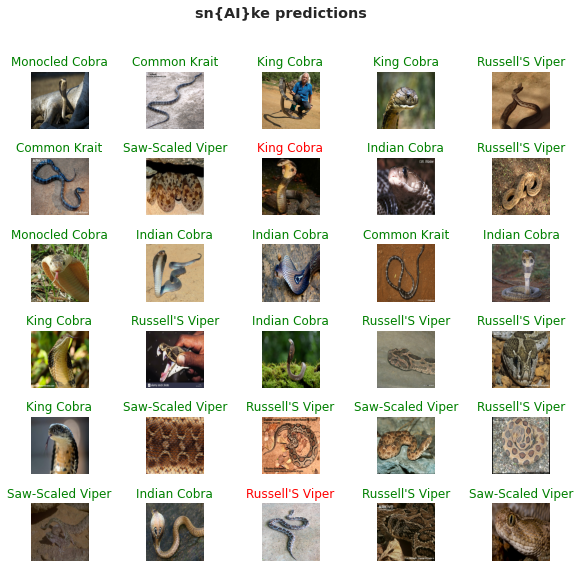

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  sns.set(font_scale=1.0)
  plt.imshow(image_batch[n])
  if tf.cast(predicted_id[n], tf.int32)==labels_batch[n]:
    plt.title(predicted_label_batch[n].title(), {'color' : 'green'})
  else:
    plt.title(predicted_label_batch[n].title(), {'color' : 'red'})
  plt.axis('off')
_ = plt.suptitle("sn{AI}ke predictions", weight='bold')

# Model Performance on Test Dataset:

Use Test dataset to evaluate the model predictions and accuracy.

In [ ]:
predicted_batch2 = snAIke.predict(image_batch2) #image_batch
predicted_id2 = tf.math.argmax(predicted_batch2, axis=-1)
predicted_label_batch2 = class_names[predicted_id2]

print(predicted_label_batch2)
print(tf.cast(predicted_id2, tf.int32))

['King Cobra' 'King Cobra' 'Indian Cobra' 'Monocled Cobra' 'Indian Cobra'
 'King Cobra' "Russell's Viper" "Russell's Viper" "Russell's Viper"
 "Russell's Viper" "Russell's Viper" 'Indian Cobra' "Russell's Viper"
 'King Cobra' "Russell's Viper" 'Monocled Cobra' 'King Cobra'
 "Russell's Viper" 'Monocled Cobra' 'King Cobra' 'King Cobra' 'King Cobra'
 "Russell's Viper" 'Common Krait' 'Saw-scaled Viper' 'Common Krait'
 "Russell's Viper" "Russell's Viper" 'Indian Cobra' 'Saw-scaled Viper'
 'Monocled Cobra' "Russell's Viper"]
tf.Tensor([2 2 1 3 1 2 4 4 4 4 4 1 4 2 4 3 2 4 3 2 2 2 4 0 5 0 4 4 1 5 3 4], shape=(32,), dtype=int32)


In [ ]:
print(labels_batch2)

tf.Tensor([3 2 1 2 1 2 5 4 4 4 4 1 4 2 4 3 2 4 3 2 2 2 4 0 5 0 4 4 3 5 3 4], shape=(32,), dtype=int32)


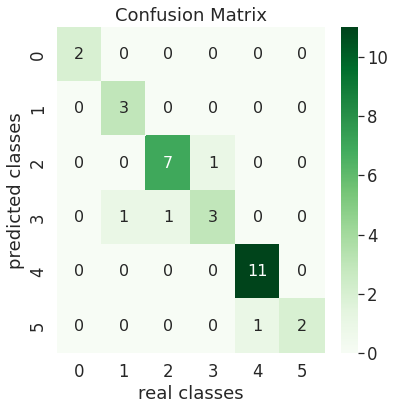

In [ ]:
# Plot Conusion Matix: 
con_mat2 = conf_matrix(labels_batch2, tf.cast(predicted_id2, tf.int32))

In [ ]:
#performance metrics calculation
FP = con_mat2.sum(axis=0) - np.diag(con_mat2)  
FN = con_mat2.sum(axis=1) - np.diag(con_mat2)
TP = np.diag(con_mat2)
TN = con_mat2.values.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print(f"Your model's true positive rate /Sensitivty is: \n{TPR}")
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print(f"Your model's true negative rate / Specificity is: \n{TNR}")
# Precision or positive predictive value
PPV = TP/(TP+FP)
print(f"Your model's positive predicted value / Precision is: \n{PPV}")
# Negative predictive value
NPV = TN/(TN+FN)
print(f"Your model's negative predicted value is: \n{NPV}")
# Fall out or false positive rate
FPR = FP/(FP+TN)
print(f"Your model's false positive rate is: \n{FPR}")
# False negative rate
FNR = FN/(TP+FN)
print(f"Your model's false negative rate is: \n{FNR}")
# False discovery rate
FDR = FP/(TP+FP)
print(f"Your model's false discovery rate is \n{FDR}")

Your model's true positive rate /Sensitivty is: 
0    1.000000
1    1.000000
2    0.875000
3    0.600000
4    1.000000
5    0.666667
dtype: float64
Your model's true negative rate / Specificity is: 
0    1.000000
1    0.965517
2    0.958333
3    0.962963
4    0.952381
5    1.000000
dtype: float64
Your model's positive predicted value / Precision is: 
0    1.000000
1    0.750000
2    0.875000
3    0.750000
4    0.916667
5    1.000000
dtype: float64
Your model's negative predicted value is: 
0    1.000000
1    1.000000
2    0.958333
3    0.928571
4    1.000000
5    0.966667
dtype: float64
Your model's false positive rate is: 
0    0.000000
1    0.034483
2    0.041667
3    0.037037
4    0.047619
5    0.000000
dtype: float64
Your model's false negative rate is: 
0    0.000000
1    0.000000
2    0.125000
3    0.400000
4    0.000000
5    0.333333
dtype: float64
Your model's false discovery rate is 
0    0.000000
1    0.250000
2    0.125000
3    0.250000
4    0.083333
5    0.000000
dtype: flo

Plot the model predictions:

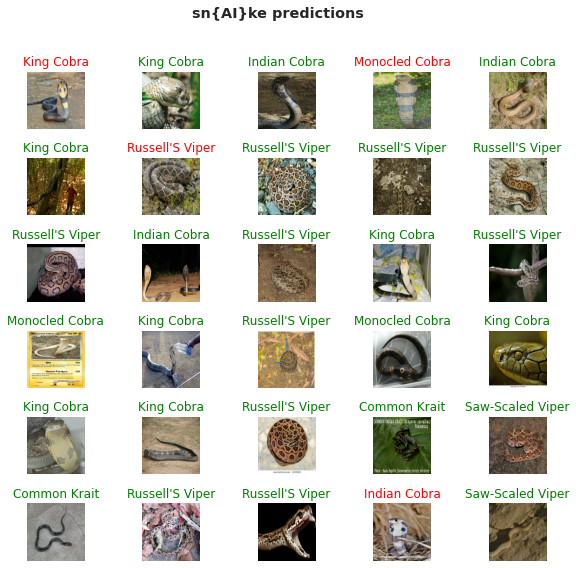

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  sns.set(font_scale=1.0)
  plt.imshow(image_batch2[n])
  if tf.cast(predicted_id2[n], tf.int32)==labels_batch2[n]:
    plt.title(predicted_label_batch2[n].title(), {'color' : 'green'})
  else:
    plt.title(predicted_label_batch2[n].title(), {'color' : 'red'})
  plt.axis('off')
_ = plt.suptitle("sn{AI}ke predictions", weight='bold')


In [ ]:
#score of the test loss and test accuracy
score = snAIke.evaluate(ds_test, verbose = 0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.5100509524345398
Test accuracy: 0.8046875


# Single Image Prediction, Model Evaluation & Linked Carachteristics:

(Tested image from the Test Dataset)

In [ ]:
# generate some integers
rnum = randint(0, 31)
print(rnum)

11


Plot the model predictions:

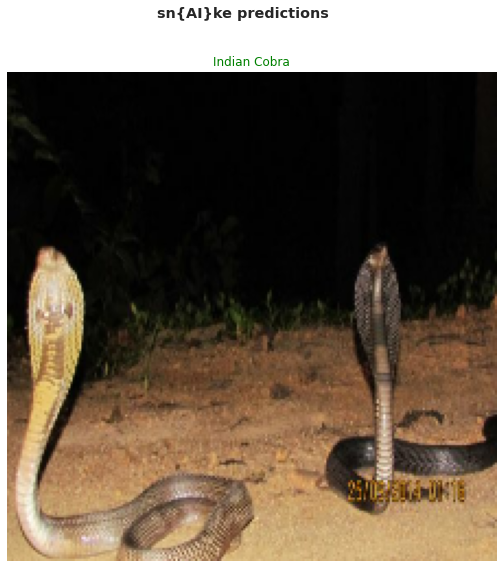

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

# plt.subplot(6,5,1+1)
plt.imshow(image_batch2[rnum])
if tf.cast(predicted_id2[rnum], tf.int32)==labels_batch2[rnum]:
  plt.title(predicted_label_batch2[rnum].title(), {'color' : 'green'})
else:
  plt.title(predicted_label_batch2[rnum].title(), {'color' : 'red'})
plt.axis('off')
_ = plt.suptitle("sn{AI}ke predictions", weight='bold')

In [ ]:
#application output
sci_name=[]
antivenom_info=[]
country_info=[]
k = 0

if tf.cast(predicted_id2[rnum], tf.int32)==labels_batch2[rnum]:
  print(f'Your snake was correctly identified!')
  for i in range(df_snakes.shape[0]):
     if df_snakes.iat[i,0] == predicted_label_batch2[rnum]:
       sci_name=df_snakes.iat[i,1]
       for j in range(df_antivenoms.shape[0]):
        if sci_name == df_antivenoms.iat[j,0]:
          antivenom_info.append(df_antivenoms.iat[j,1])
          country_info.append(df_antivenoms.iat[j,3])
          k += 1

  print(f"Your snake's scientific name is \033[3m {sci_name} \033[0m")
  print(f"And these are the available antivenoms:")
  for l in range(len(antivenom_info)):
    print(f"\t * {antivenom_info[l] : <40} - {country_info[l]: ^10}")

else:
  print(f'Your snake was mistakently identified as {predicted_label_batch2[rnum]}.')
  print(f'WARNING: Cannot give you an accurate Antivenom!')


Your snake was correctly identified!
Your snake's scientific name is  Naja naja 
And these are the available antivenoms:
	 * Snake venom antiserum I.P.               -   India   
	 * Snake Venom Antiserum I.P. (Asia)        -   India   
	 * Polyvalent Anti Snake Venom Serum I.P.   -   India   
	 * Polyvalent Antisnake Venom Serum         -  Pakistan 
	 * Snake Venom Antiserum (Polyvalent)       -   India   
	 * Polyvalent Snake Antivenin (Asia)        -   India   
	 * Snake antivenin I.P. (Asia)              -   India   


## TensorFlowLite:
https://www.tensorflow.org/lite/api_docs/python/tf/lite/TFLiteConverter

In [ ]:
# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(snAIke)
tflite_snAIke = converter.convert()